# 0.1 Implementing the Combinatorial Generalization Task

Designing the combinatorial task that will be used for the 0.0 release. See the [readme](combinatorics.rst) for more detail on the task.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,pandas,matplotlib,seaborn

Thu Feb 14 2019 01:15:10 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
pandas 0.24.1
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 016fe750436621c5f43133787c21d99b9dca7903
Git branch : task


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [8]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## Visualizing the Task

The heart of the task is creating a mapping from a $n$x$n$ boolean matrix to a $n$x$2$ boolean matrix. Below is an example of what the resulting $n$x$2$ matrix should look like.


In [71]:
example_y = np.random.choice(2, (5,2), True)
print(example_y)

[[0 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]]


Visualizing this using a heatmap will probably be an easier way to make sense of it.

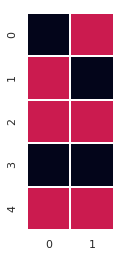

In [72]:
sns.heatmap(example_y, vmin=0, vmax=2, cbar=False, linewidths=1, square=True)
plt.show()

Let's turn this setup into a function, with the specific defaults to produce the above plot.

In [73]:
def heatmap(data, vmin=0, vmax=2, cbar=False, linewidths=1, square=True, 
            *args, **kwargs):
    """Wrapper function of `sns.heatmap` with some different defaults. 
    
    Only changed values are shown, see the documentation for `sns.heatmap`
    for all available parameters.
        
    Parameters
    ----------
    vmin : float, optional
        Min color. Now set to 0
        
    vmax : float, optional
        Max color. Now set to 2
        
    cbar : bool, optional
        Color bar present or not. Now set to False
        
    linewidths : float, optional
        Width of lines between boxes. Now set to 1
        
    square : bool, optional
        Maintain aspect ratio. Now set to True
    """
    sns.heatmap(data, vmin=vmin, vmax=vmax, cbar=cbar,
                linewidths=linewidths, square=square, *args, **kwargs)

And sanity checking things:

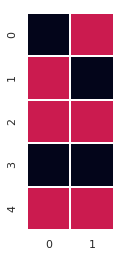

In [75]:
heatmap(example_y)
plt.show()

Moving on to the inputs that wouild generate this, putting it together by hand it would look like this: 

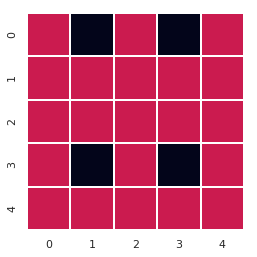

In [77]:
example_x = np.array([[1, 0, 1, 0, 1],
                      [1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1],
                      [1, 0, 1, 0, 1],
                      [1, 1, 1, 1, 1]])
heatmap(example_x)

## Inverse Transform

So let's try to put together a straight forward implementation of the mapping from `y` to `x` so we can start generating data.

In [387]:
def inverse_transform_first_pass(y):
    """Turns the inputted nxn array into the nx2 array
    
    Parameters
    ----------
    y : array-like (nx2)
        The the label we are transforming.
        
    Returns
    -------
    x : np.array (nxn)
        The `x` that would have generated the inputted `y`.
    """
    # Grab the length of y
    n = len(y)
    # Create a horizontal array and a vertical array according to y
    horizontal, vertical = np.tile(y, n).reshape(n, n, 2).T
    return (horizontal.T + vertical).astype(bool)

generated_x = inverse_transform_first_pass(example_y)
# Quick check of the function
assert np.array_equal(generated_x, example_x)
logger.info('Passed!')

2019-02-14 19:15:34 apra-xps13 leabratf[23007] INFO Passed!


And in case we aren't convinved, here is a plot of `y`, the expected `x` and the generated `x`:

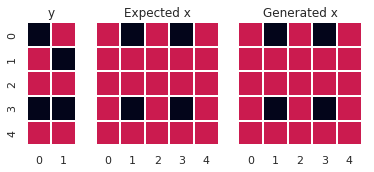

In [160]:
# Create 3 subplots with the same y, and set the width ratios
_, axn = plt.subplots(1, 3, sharey=True, 
                      gridspec_kw={'width_ratios': [2, 5, 5]})
# Create a list of the titles for each
titles = ['y', 'Expected x', 'Generated x']
# Create a list of values we will pass into the heatmap
values = [example_y, example_x, generated_x]

# Loop through and generate the plots
for i, ax in enumerate(axn):
    heatmap(values[i], ax=ax)
    ax.set_title(titles[i])
plt.show()

Now that we're satisfied, let's revisit the line that generates the `y` values:
```
example_y = np.random.choice(2, (5,2), True)
```

This generates a single `y` which will be fed into `inverse_transform_first_pass` to generate a single `x`. Let's ensure the function above can take in an array of `y`s of arbitrary length - call it capital `Y`, and output all the `x`s, or just capital `X`.

In [302]:
# Number of samples to generate, starting off real simple
N = 3
# Input Y data
example_Y = np.random.choice(2, (N,5,2), True)
# Let's see if it even runs
inverse_transform_first_pass(example_Y)

ValueError: cannot reshape array of size 90 into shape (3,3,2)

Of course not, we're making too may assumptions about the shape. We probably can't visualize it either.

In [164]:
heatmap(example_Y)

ValueError: Must pass 2-d input

## Going 3-D

Before going into actually making changes, one thing that will be useful is to create a decorator that does nothing but turn 2D arrays into 3D ones by reshaping in an extra dimension.

In [369]:
# Decorator that transfers documentation of the wrapped function to the
# decorated one.
from functools import wraps

def make_input_3d(function, *args, **kwargs):
    """Looks at the first argument of a function and if it is an array,
    and is 2D, it will make it 3D by just reshaping in another one.
    """
    @wraps(function)
    def decorator(*args, **kwargs):
        # Check to make sure its an array
        if isinstance(args[0], np.ndarray):
            # Turn it to a list so we can change it
            args = list(args)
            # Pull out the shape
            shape = args[0].shape
            # If it is of shape 2, add in an extra dim at the start.
            if len(shape) == 2:
                args[0] = args[0].reshape(1, *shape)
        # Return the passed function
        return function(*args, **kwargs)
    return decorator

And let's just make sure it does what we expect it to.

In [388]:
@make_input_3d
def test_function(data):
    """
    Simply return the inputted data, after being fed through the 
    generator.
    """
    return data

test_data = np.ones((2,2))
# Sanity check
assert np.array_equal(test_data.shape, (2,2))
reshaped_data = test_function(test_data)
# The actual test we are after
message = 'Got array shape of {0}, expected {1}'.format(
    reshaped_data.shape, (1,2,2))
assert np.array_equal(reshaped_data.shape, (1,2,2)), message

logger.info('Passed!')

2019-02-14 19:16:02 apra-xps13 leabratf[23007] INFO Passed!


Alright, now that it's working, let's fix the visualization first.

In [372]:
# General warning, this will overwrite the originally defined heatmap
@make_input_3d
def heatmap(data, vmin=0, vmax=2, cbar=False, linewidths=1, square=True, 
            samples_per_row=10, *args, **kwargs):
    """Wrapper function of `sns.heatmap` with some different defaults. 
    
    Only changed values are shown, see the documentation for `sns.heatmap`
    for all available parameters.
        
    Parameters
    ----------
    vmin : float, optional
        Min color. Now set to 0
        
    vmax : float, optional
        Max color. Now set to 2
        
    cbar : bool, optional
        Color bar present or not. Now set to False
        
    linewidths : float, optional
        Width of lines between boxes. Now set to 1
        
    square : bool, optional
        Maintain aspect ratio. Now set to True
        
    samples_per_row : int, optional
        Number of samples to have in a plotting row before creating a 
        new row
    """
    # Place them all in a subplot
    n_samples = len(data)
    ver_size = n_samples // samples_per_row
    ver_size = ver_size + 1 if n_samples % samples_per_row else ver_size
    
    hor_size = (samples_per_row 
                if (ver_size > 1 or n_samples == samples_per_row) 
                else n_samples % samples_per_row)
    
    _, axn = plt.subplots(ver_size, hor_size, sharey=True, sharex=True,
                          squeeze=False)
    
    # Loop through and generate the plots
    gen_data = iter(data)
    for i in range(ver_size):
        try:
            for j in range(hor_size):
                sns.heatmap(next(gen_data), vmin=vmin, vmax=vmax, cbar=cbar,
                            linewidths=linewidths, square=square, ax=axn[i,j], 
                            *args, **kwargs)
                axn[i,j].set_title(i*ver_size + j)
        except StopIteration:
            break

And then now let's test it for various inputs.

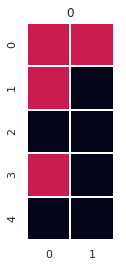

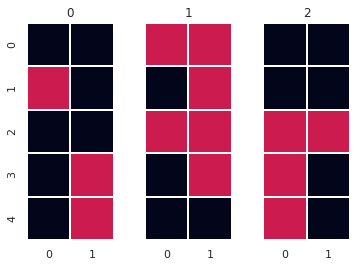

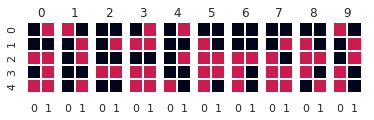

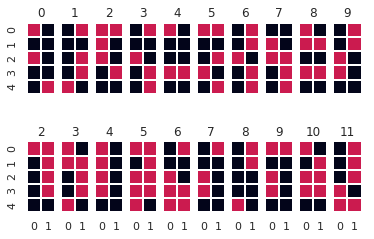

In [382]:
example_sample_lengths = [1, 3, 10, 20]
for length in example_sample_lengths:
    heatmap(np.random.choice(2, (length,5,2), True))
    plt.show()

For the inverse transform, there are probably some ways that are better than others. So need to test at least a couple and see how they perform.

So let's start with a testing function.

In [389]:
def test_inverse_transform_func(func):
    """Test function that takes an inverse transform function and tests
    it against different lengths of Y. It uses the inverse transform function 
    defined above as the ground truth.
    
    Parameters
    ----------
    func : function
        Inverse transform function that takes at least one argument, Y
        
    Raises
    ------
    `AssertionError`
        If one of the assertions fail
    """
    for length in example_sample_lengths:
        # Create the example Y
        example_Y = np.random.choice(2, (length,5,2), True)
        # Create the ground truth
        true_X = [inverse_transform_first_pass(y) for y in example_Y]
        # Run the function we are testing.
        generated_X = func(example_Y)
                   
        # Loop through each generated x and compare it with the true x
        for true_x, gen_x in zip(true_X, generated_X):
            # The message in case it fails
            message = 'Func returned array {0}, expected {1}'.format(
                true_x, gen_x)
            assert np.array_equal(true_x, gen_x), message
    logger.info('Passed!')

And now to test the test.

In [391]:
# The same function that's used in the test
test_func = lambda Y: [inverse_transform_first_pass(y) for y in Y]
test_inverse_transform_func(test_func)

2019-02-14 19:40:56 apra-xps13 leabratf[23007] INFO Passed!


## Performance Testing

And the last thing we probably want is a way to time the functions to compare them.

In [405]:
# Import isiterable
from leabratf.utils import isiterable

def time_funcs(funcs, sample_lengths=None):
    """Times all the funcs """
    # Ensure the functions are in some iterable object
    if not isiterable(funcs):
        funcs = [funcs]
        
    # Set the default test lengths
    if sample_lengths is None:
        sample_lengths = [1, 10, 100, 1000]
        
    # Loop through each of the functions    
    for i, func in enumerate(funcs):
        print(' - Testing function {}'.format(i))
        # Try different orders of magnitudes for the times
        for sample_length in sample_lengths:
            print('Testing with Y of length {}'.format(sample_length))
            %timeit func(np.random.choice(2, (sample_length,5,2), True))

And then now let's make sure it prints what we think it should, and establish a baseline with a straight list comprehension.

In [406]:
# Test with one instance of the test function
time_funcs(test_func)

 - Testing function 0
Testing with Y of length 1
37.4 µs ± 5.45 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Testing with Y of length 10
166 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Testing with Y of length 100
1.06 ms ± 82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Testing with Y of length 1000
11.3 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [407]:
# And now test with passing a list of 2 of the test function
time_funcs(2*[test_func])

 - Testing function 0
Testing with Y of length 1
31.3 µs ± 5.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Testing with Y of length 10
135 µs ± 7.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Testing with Y of length 100
1.49 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Testing with Y of length 1000
15.5 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
 - Testing function 1
Testing with Y of length 1
27.9 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Testing with Y of length 10
144 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Testing with Y of length 100
1.14 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Testing with Y of length 1000
11.9 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Seems like it scales fairly linearly starting on the order of 10 $\mu$$s$ per sample. And assuming that we wanted to generate as many samples as there are possible combinations of lines for four 5 by 5 grids (~4 million), this would only take about 40s.

So rather than trying to really be smart about things, let's just use this base implementation until we start running into any bottlenecks.

Just to be complete though, the final implementation as it stands would be the following:

In [443]:
@make_input_3d
def inverse_transform(Y, *args, **kwargs):
    """Wrapper for first pass implementation that accounts for multiple
    samples."""
    return [inverse_transform_first_pass(y) for y in Y]

And then just for completeness, let's just run the testing and timing functions.

In [448]:
# Test the function.
print('Testing inverse transform...')
test_inverse_transform_func(inverse_transform)

sample_lengths = [100, 1000, 10000, 100000]
print('Timing inverse transform with {} samples...'
            ''.format(sample_lengths))
time_funcs(inverse_transform, sample_lengths)
print('Completed!')

2019-02-14 21:46:32 apra-xps13 leabratf[23007] INFO Passed!


Testing inverse transform...
Timing inverse transform with [100, 1000, 10000, 100000] samples...
 - Testing function 0
Testing with Y of length 100
1.29 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing with Y of length 1000
10.2 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Testing with Y of length 10000
103 ms ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Testing with Y of length 100000
1.04 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Completed!
